<a href="https://colab.research.google.com/github/BaishaliChetia/CapsNet-Keras/blob/master/a_cifarTf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original implementation at:

https://github.com/ageron/handson-ml/blob/master/extra_capsnets.ipynb

Geron's model doesn't use the keras functional API. In the keras functional API, you don't need to give the batchsize. 

When you print the model, you get this:

```
Layer (type)                 Output Shape              Param #   
_________________________________________________________________
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_layer_1 (Conv2D)        (None, 20, 20, 256)       20992     
_________________________________________________________________
conv_layer_2 (Conv2D)        (None, 6, 6, 256)         5308672   
_________________________________________________________________
reshape_layer_1 (Reshape)    (None, 1, 1152, 8)        0         
_________________________________________________________________
caps1_output_layer (SquashLa (None, 1, 1152, 8)        0         
_________________________________________________________________
Total params: 5,329,664
Trainable params: 5,329,664
Non-trainable params: 0
```

Notice that the Input-layer has shape (None, 28, 28, 1), but we only specified (28, 28, 1). It added None implicitly and that takes care of the batch.

So for anywhere Geron uses the batch size explicitly, you don't need to do anything and tensorflow will take care of.

Also note that tensorflow 1 APIs are still provided with the compat layer. I used the reduce_sum from TF1 in the squash layer, that allowed me to use Geron's code.

Documentation on how to migrate from TF1 to TF2 can be found here:

https://www.tensorflow.org/guide/migrate


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import tensorflow.keras as K

In [3]:
(x_train, y_train), (x_test, y_test) = K.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [4]:
x_train = x_train/255.0
x_test = x_test/255.0

In [5]:
caps1_n_maps = 32
caps1_n_caps = caps1_n_maps * 13 * 13   
caps1_n_dims = 16
caps2_n_caps = 10
caps2_n_dims = 32

tf.random.set_seed(42)

In [6]:
class SquashLayer(K.layers.Layer):
  def __init__(self, axis=-1, **kwargs):
    super(SquashLayer, self).__init__(**kwargs)
    self.axis = axis
    
  def build(self, input_shapes):
    pass

  def call(self, inputs):
    EPSILON = 1.0e-5
    squared_norm = tf.compat.v1.reduce_sum(tf.square(inputs),\
                                           axis=self.axis,\
                                           keepdims=True)
    safe_norm = tf.sqrt(squared_norm + EPSILON)
    squash_factor = squared_norm / (1. + squared_norm)
    unit_vector = inputs / safe_norm
    return squash_factor * unit_vector


In [7]:
class SafeNorm(K.layers.Layer):
  
  def __init__(self, axis=-1, keep_dims = False,  **kwargs):
    super(SafeNorm, self).__init__(**kwargs)
    self.axis = axis
    self.keep_dims = keep_dims

  def build(self, input_shapes):
    pass

  def call(self, input):
    EPSILON = 1.0e-5
    squared_norm = tf.compat.v1.reduce_sum(tf.square(inputs),\
                                           axis=self.axis,\
                                           keepdims= self.keep_dims)
    safe_norm = tf.sqrt(squared_norm + EPSILON)
    return safe_norm



In [8]:
# This should be the part where the digit layer, and where we tile things
# This is incomplete, and work in progress
# TODO: Complete this
class MyDigitCapsLayer(K.layers.Layer):
  def __init__(self, **kwargs):
    super(MyDigitCapsLayer, self).__init__(**kwargs)

  def build(self, input_shapes):
    init_sigma = 0.1  # TODO: use
    self.kernel = self.add_weight(\
                      "kernel",\
                      (caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),\
                      initializer=K.initializers.RandomNormal(stddev=0.1),\
                      dtype=tf.float32)

  
  # To debug this function, I used prints to print the shape
  # expand_dims just adds an exis, so if you say expand_dims(inshape=(5, 3), -1),
  # you get the output shape (5, 3, 1), it just adds an axis at the end
  # Then tile just multiplies one of the dimensions (that is it stacks along that direction N times)
  # so tile(inshape=(5, 3, 1), [1, 1, 1000]) will yield a shape (5, 3, 1000)
  #
  # Notice I didn't tile in build, but in call, Most probaly this is the right thing to do
  # but we'll only figure out when we actually train
  def call(self, inputs):
    # Add a dimension at the end
    exp1 = tf.expand_dims(inputs, -1, name="caps1_output_expanded")
    # add a dimension along 3rd axis
    exp1 = tf.expand_dims(exp1, 2, name="caps2_output_espanced")
    # tile along 3rd axis
    tile = tf.tile(exp1, [1, 1, caps2_n_caps, 1, 1], name="caps1_output_tiled")
    caps2_predicted = tf.matmul(self.kernel, tile, name="caps2_predicted")
    return caps2_predicted

In [9]:
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/Loss
class MarginLoss(K.losses.Loss):
    def __init__(self, **kwargs):
      super(MarginLoss, self).__init__(**kwargs)
    
    def safe_norm(self, input, axis=-2, epsilon=1e-7, keep_dims=False, name=None):
      squared_norm = tf.reduce_sum(tf.square(input), axis=axis,
                                     keepdims=keep_dims)
      return tf.sqrt(squared_norm + epsilon)

    

    def call(self,y_true, input):
      #print("Loss", y_true.shape, input.shape)
      # with open ("/tmp/file2.txt", "w") as f:
      #   f.write(f"margin_loss: {y_true.shape} {input.shape}")
      #   f.close()
      # print(f"y_true.shape = {y_true.shape}, y_pred.shape = {y_pred.shape}")
      # return K.losses.MeanSquaredError()(y_true, y_pred)

      #y_true = K.Input(shape=[], dtype=tf.int64, name="y")
      m_plus = 0.9
      m_minus = 0.1
      lambda_ = 0.5 
      
      #y_true one hot encode y_train
      T = tf.one_hot(y_true, depth=caps2_n_caps, name="T")
      
      caps2_output_norm = self.safe_norm(input, keep_dims = True)

      present_error_raw = tf.square(\
                                    tf.maximum(0., m_plus - caps2_output_norm),
                                    name="present_error_raw")
      present_error = tf.reshape(\
                                    present_error_raw, shape=(-1, 10),
                                    name="present_error")  
  
      absent_error_raw = tf.square(\
                                    tf.maximum(0., caps2_output_norm - m_minus),
                                    name="absent_error_raw")
      absent_error = tf.reshape(\
                                    absent_error_raw, shape=(-1, 10),
                                    name="absent_error")
  
      L = tf.add(\
                  T * present_error,\
                  lambda_ * (1.0 - T) * absent_error,
                  name="L")
      marginLoss = tf.reduce_mean(\
                                  tf.reduce_sum(L, axis=1),\
                                  name="margin_loss")
      return marginLoss



In [10]:
class RoutingByAgreement(K.layers.Layer):
  def __init__(self, roundno=-1, **kwargs):
    super(RoutingByAgreement, self).__init__(**kwargs)
    self.round_number = roundno

  def build(self, input_shapes):
    self.raw_weights_1 = self.add_weight("raw_weights", \
                                         (caps1_n_caps, caps2_n_caps, 1, 1), \
                                         initializer = "zeros", \
                                         dtype=tf.float32,)
    
    #print("Routing layer: self.raw_weights = ", self.raw_weights.shape, "input_shape = ", input_shapes)


  @staticmethod
  def squash(inputs):
    EPSILON = 1.0e-7
    squared_norm = tf.compat.v1.reduce_sum(tf.square(inputs),\
                                           keepdims=True)
    safe_norm = tf.sqrt(squared_norm + EPSILON)
    squash_factor = squared_norm / (1. + squared_norm)
    unit_vector = inputs / safe_norm
    return squash_factor * unit_vector

  def single_round_routing(self, inputs, raw_weights, agreement):
    raw_weights = tf.add(raw_weights, agreement)
    routing_wt = tf.nn.softmax(raw_weights, axis=2)
    wt_predictions = tf.multiply(routing_wt, inputs)
    wt_sum = tf.reduce_sum(wt_predictions, axis=1, keepdims=True)
    return wt_sum

  def call(self, inputs):
    agreement = tf.zeros(shape=self.raw_weights_1.shape)
    sqsh_wt_sum = None
    x = inputs
    for i in range(3):
      wt_sum = self.single_round_routing(inputs, self.raw_weights_1, agreement)
      sqsh_wt_sum = RoutingByAgreement.squash(wt_sum)
      sqsh_wt_sum_tiled = tf.tile(\
                          sqsh_wt_sum ,\
                          [1, caps1_n_caps, 1, 1, 1],\
                          name="caps2_output_round_1_tiled")
      agreement = tf.matmul(\
                            x, \
                            sqsh_wt_sum_tiled,\
                            transpose_a=True,\
                            name="agreement")
    return sqsh_wt_sum                           


In [11]:

# (x_train, y_train,), (x_test, y_test) = K.datasets.mnist.load_data()
# print(x_train.shape, x_test.shape)

In [11]:
class Model:
    @staticmethod
    def build(inshape=(32, 32, 3)):
        inp = K.Input(shape=inshape, dtype=tf.float32, name='input')
        
        # Primary capsules
        # For each digit in the batch
        # 32 maps, each 6x6 grid of 8 dimensional vectors
        
        # First Conv layer
        conv1_params = \
        {
            "filters": 256,
            "kernel_size": 3,
            "strides": 1,
            "padding": "valid",
            "activation": tf.nn.relu,
        }
        x = K.layers.Conv2D(**conv1_params, name="conv_layer_1")(inp)

        x = K.layers.Conv2D(**conv1_params, name="conv_layer_mid")(x)
        
        # Second conv layer
        conv2_params = \
        {
            "filters": caps1_n_maps * caps1_n_dims, # 256 convolutional filters
            "kernel_size": 3,
            "strides": 2,
            "padding": "valid",
            "activation": tf.nn.relu
        }
        x = K.layers.Conv2D(**conv2_params, name="conv_layer_2")(x)
        
        # Reshape
        x = K.layers.Reshape(\
                             (caps1_n_caps, caps1_n_dims),\
                             name="reshape_layer_1")(x)
                             
        x = SquashLayer(name="caps1_output_layer")(x)
        
        x = MyDigitCapsLayer(name = "caps2_predicted")(x)
        caps2_predicted = x # Save this value for later
        
        #routing by agreement (2 rounds)
        x = RoutingByAgreement(name="routing1", roundno=2)(x)
        
        return K.Model(inputs=inp, outputs=x, name='my')
    
m = Model.build()
print(m.summary())


Model: "my"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv_layer_1 (Conv2D)        (None, 30, 30, 256)       7168      
_________________________________________________________________
conv_layer_mid (Conv2D)      (None, 28, 28, 256)       590080    
_________________________________________________________________
conv_layer_2 (Conv2D)        (None, 13, 13, 512)       1180160   
_________________________________________________________________
reshape_layer_1 (Reshape)    (None, 5408, 16)          0         
_________________________________________________________________
caps1_output_layer (SquashLa (None, 5408, 16)          0         
_________________________________________________________________
caps2_predicted (MyDigitCaps (None, 5408, 10, 32, 1)   27688960 

In [13]:
# y_train_train = tf.one_hot(y_train, depth=caps2_n_caps, name="T")
# print(y_train_train.shape)
# #print(y_train)
#x_train = x_train/255.0

In [12]:
class MyAccuracy(K.metrics.Metric):
  def __init__(self, **kwargs):
    super(MyAccuracy, self).__init__(**kwargs)
    self.acc_obj = K.metrics.Accuracy()
    self.state = 0
  
  def safe_norm(self, input, axis=-2, epsilon=1e-7, keep_dims=True, name=None):
      squared_norm = tf.reduce_sum(tf.square(input), axis=axis,
                                     keepdims=keep_dims)
      return tf.sqrt(squared_norm + epsilon)

  def update_state(self, y_true, input, sample_weight=None):
    y_proba = self.safe_norm(input, axis=-2)

    y_proba_argmax = tf.argmax(y_proba, axis=2)
    y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")
    #print("--", y_pred.shape, y_true.shape)
    y_true = tf.cast(y_true, dtype=tf.int64)
    self.acc_obj.update_state(y_true, y_pred, sample_weight)

  def reset_state(self):
    self.acc_obj.reset_state()

  def result(self):
    return self.acc_obj.result()

In [ ]:
m.compile(optimizer=K.optimizers.Adam(), loss=MarginLoss(), metrics=[comparison_metric])
history = m.fit(x_train, y_train, batch_size=32, epochs=50, verbose= 1, validation_split=0.3, callbacks = callback_list, use_multiprocessing=True)


Epoch 1/50
1094/1094 [==============================] - 577s 512ms/step - loss: 2.2820 - my_accuracy: 0.0996 - val_loss: 2.2800 - val_my_accuracy: 0.1005
Epoch 2/50
1094/1094 [==============================] - 531s 486ms/step - loss: 2.2807 - my_accuracy: 0.1018 - val_loss: 2.2802 - val_my_accuracy: 0.0984
Epoch 3/50
1094/1094 [==============================] - 579s 529ms/step - loss: 2.2805 - my_accuracy: 0.0964 - val_loss: 2.2794 - val_my_accuracy: 0.1014
Epoch 4/50
1094/1094 [==============================] - 536s 490ms/step - loss: 2.2804 - my_accuracy: 0.1009 - val_loss: 2.2799 - val_my_accuracy: 0.1014
Epoch 5/50
1094/1094 [==============================] - 534s 489ms/step - loss: 2.2803 - my_accuracy: 0.1005 - val_loss: 2.2800 - val_my_accuracy: 0.0984
Epoch 6/50
1094/1094 [==============================] - 527s 482ms/step - loss: 2.2802 - my_accuracy: 0.1010 - val_loss: 2.2799 - val_my_accuracy: 0.0984
Epoch 7/50
1094/1094 [==============================] - 523s 478ms/step - lo

In [ ]:
# print(f'Best Validation Accuracy = {np.max(history.history[f"val_{comparison_metric.name}"])}')
# print(f'Best Training   Accuracy = {np.max(history.history[f"{comparison_metric.name}"])}')

In [18]:
m2 = Model.build()
m2.load_weights("/content/drive/MyDrive/WeightsCifar10/latest_weights.hdf5")
m2.compile(optimizer='adam', loss=MarginLoss(), metrics=[comparison_metric])
history = m2.fit(x_train, y_train, batch_size=32, epochs=40, verbose= 1, validation_split=0.2, callbacks = callback_list )

Epoch 1/40
1250/1250 [==============================] - 467s 358ms/step - loss: 2.2802 - my_accuracy_3: 0.1803 - val_loss: 2.2783 - val_my_accuracy_3: 0.2217
Epoch 2/40
1250/1250 [==============================] - 446s 357ms/step - loss: 2.2802 - my_accuracy_3: 0.1986 - val_loss: 2.2782 - val_my_accuracy_3: 0.1723
Epoch 3/40
1250/1250 [==============================] - 446s 357ms/step - loss: 2.2802 - my_accuracy_3: 0.1919 - val_loss: 2.2781 - val_my_accuracy_3: 0.2002
Epoch 4/40
1250/1250 [==============================] - 447s 357ms/step - loss: 2.2802 - my_accuracy_3: 0.2103 - val_loss: 2.2783 - val_my_accuracy_3: 0.2337
Epoch 5/40
1250/1250 [==============================] - 447s 357ms/step - loss: 2.2802 - my_accuracy_3: 0.2070 - val_loss: 2.2783 - val_my_accuracy_3: 0.1306
Epoch 6/40
1250/1250 [==============================] - 447s 357ms/step - loss: 2.2802 - my_accuracy_3: 0.2119 - val_loss: 2.2784 - val_my_accuracy_3: 0.1976
Epoch 7/40
1250/1250 [==============================

In [19]:
import pickle
with open('/content/drive/MyDrive/WeightsCifar10/history_round2_ep40', 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

In [20]:
print(f'Best Validation Accuracy = {np.max(history.history[f"val_{comparison_metric.name}"])}')
print(f'Best Training   Accuracy = {np.max(history.history[f"{comparison_metric.name}"])}')

Best Validation Accuracy = 0.3736000061035156
Best Training   Accuracy = 0.33467501401901245


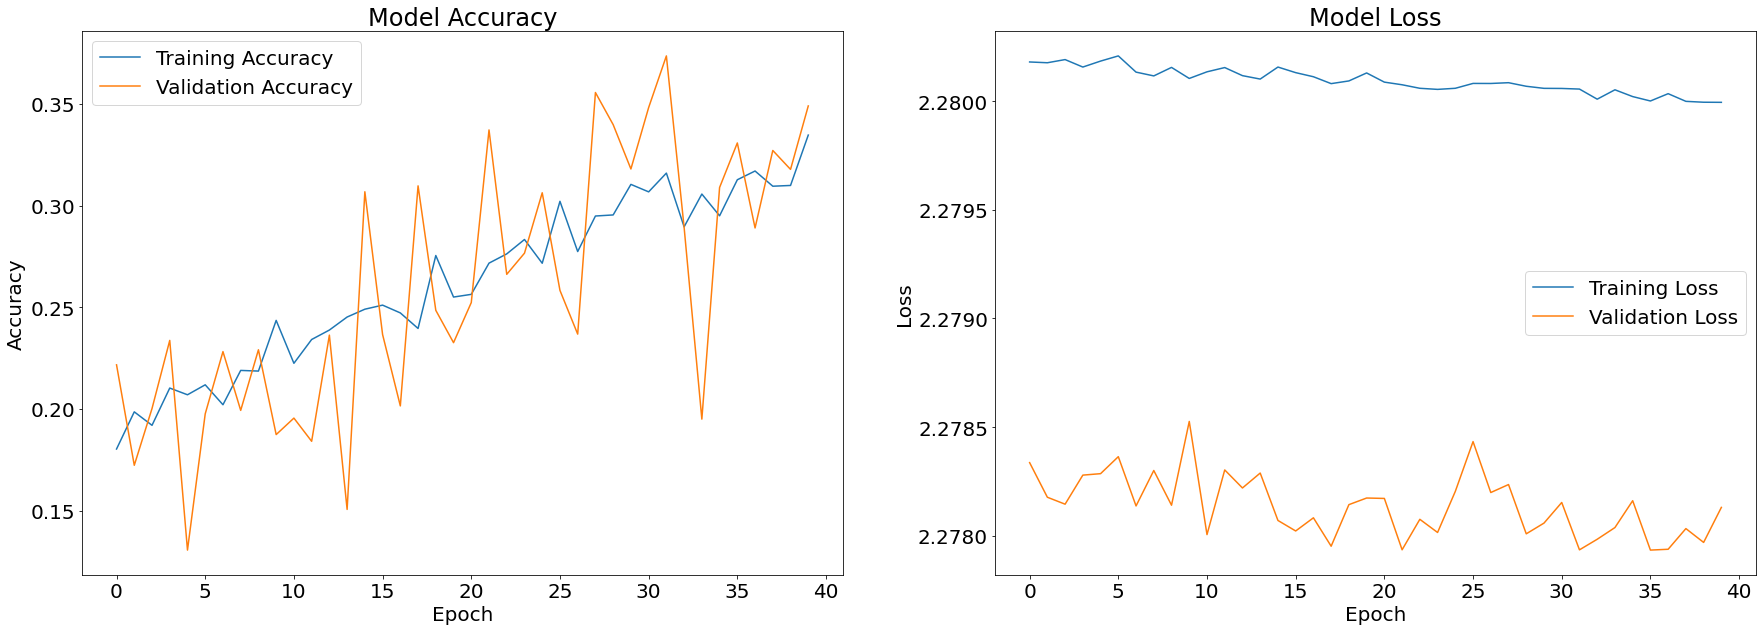

In [21]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (30, 10)
plt.rcParams["font.size"] = 20

fig, ax = plt.subplots(1, 2)

ax[0].plot(history.history[f"{comparison_metric.name}"])
ax[0].plot(history.history[f"val_{comparison_metric.name}"])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Training Accuracy', 'Validation Accuracy'], loc='best')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Training Loss', 'Validation Loss'], loc='best')
plt.show()


In [23]:
m3 = Model.build()
m3.load_weights("/content/drive/MyDrive/WeightsCifar10/latest_weights2.hdf5")
m3.compile(optimizer='adam', loss=MarginLoss(), metrics=[comparison_metric])
history = m3.fit(x_train, y_train, batch_size=32, epochs=50, verbose= 1, validation_split=0.2, callbacks = callback_list )

Epoch 1/50
1250/1250 [==============================] - 444s 351ms/step - loss: 2.2800 - my_accuracy_4: 0.3337 - val_loss: 2.2781 - val_my_accuracy_4: 0.3594
Epoch 2/50
1250/1250 [==============================] - 447s 358ms/step - loss: 2.2800 - my_accuracy_4: 0.3403 - val_loss: 2.2780 - val_my_accuracy_4: 0.3174
Epoch 3/50
1250/1250 [==============================] - 447s 358ms/step - loss: 2.2800 - my_accuracy_4: 0.3184 - val_loss: 2.2779 - val_my_accuracy_4: 0.3517
Epoch 4/50
1250/1250 [==============================] - 447s 357ms/step - loss: 2.2800 - my_accuracy_4: 0.3407 - val_loss: 2.2781 - val_my_accuracy_4: 0.3372
Epoch 5/50
1250/1250 [==============================] - 446s 357ms/step - loss: 2.2800 - my_accuracy_4: 0.3384 - val_loss: 2.2781 - val_my_accuracy_4: 0.2730
Epoch 6/50
1250/1250 [==============================] - 446s 357ms/step - loss: 2.2800 - my_accuracy_4: 0.3523 - val_loss: 2.2781 - val_my_accuracy_4: 0.3603
Epoch 7/50
1250/1250 [==============================

In [27]:
m4 = Model.build()
m4.load_weights("/content/drive/MyDrive/WeightsCifar10/latest_weights3.hdf5")
m4.compile(optimizer='adam', loss=MarginLoss(), metrics=[comparison_metric])
history = m4.fit(x_train, y_train, batch_size=32, epochs=30, verbose= 1, validation_split=0.2, callbacks = callback_list )

Epoch 1/30
1250/1250 [==============================] - 453s 358ms/step - loss: 2.2799 - my_accuracy_5: 0.4257 - val_loss: 2.2780 - val_my_accuracy_5: 0.4196
Epoch 2/30
1250/1250 [==============================] - 447s 358ms/step - loss: 2.2799 - my_accuracy_5: 0.4214 - val_loss: 2.2778 - val_my_accuracy_5: 0.4099
Epoch 3/30
1250/1250 [==============================] - 447s 358ms/step - loss: 2.2799 - my_accuracy_5: 0.4074 - val_loss: 2.2779 - val_my_accuracy_5: 0.4127
Epoch 4/30
1250/1250 [==============================] - 447s 357ms/step - loss: 2.2799 - my_accuracy_5: 0.4185 - val_loss: 2.2780 - val_my_accuracy_5: 0.4091
Epoch 5/30
1250/1250 [==============================] - 446s 357ms/step - loss: 2.2799 - my_accuracy_5: 0.4185 - val_loss: 2.2779 - val_my_accuracy_5: 0.3518
Epoch 6/30
1250/1250 [==============================] - 446s 357ms/step - loss: 2.2799 - my_accuracy_5: 0.4351 - val_loss: 2.2780 - val_my_accuracy_5: 0.4287
Epoch 7/30
1250/1250 [==============================

In [ ]:
m5 = Model.build()
m5.load_weights("/content/drive/MyDrive/WeightsCifar10/latest_weights4.hdf5")
m5.compile(optimizer='adam', loss=MarginLoss(), metrics=[comparison_metric])
history = m5.fit(x_train, y_train, batch_size=32, epochs=50, verbose= 1, validation_split=0.2, callbacks = callback_list )

Epoch 1/50
1250/1250 [==============================] - 450s 356ms/step - loss: 2.2798 - my_accuracy_6: 0.4582 - val_loss: 2.2780 - val_my_accuracy_6: 0.4480
Epoch 2/50
1250/1250 [==============================] - 436s 349ms/step - loss: 2.2798 - my_accuracy_6: 0.4514 - val_loss: 2.2778 - val_my_accuracy_6: 0.4358
Epoch 3/50
1250/1250 [==============================] - 438s 350ms/step - loss: 2.2799 - my_accuracy_6: 0.4403 - val_loss: 2.2778 - val_my_accuracy_6: 0.4463
Epoch 4/50
1250/1250 [==============================] - 438s 351ms/step - loss: 2.2798 - my_accuracy_6: 0.4511 - val_loss: 2.2780 - val_my_accuracy_6: 0.4245
Epoch 5/50
1250/1250 [==============================] - 439s 351ms/step - loss: 2.2798 - my_accuracy_6: 0.4498 - val_loss: 2.2779 - val_my_accuracy_6: 0.3881
Epoch 6/50
1250/1250 [==============================] - 439s 351ms/step - loss: 2.2799 - my_accuracy_6: 0.4671 - val_loss: 2.2780 - val_my_accuracy_6: 0.4546
Epoch 7/50
1250/1250 [==============================

In [15]:
m6 = Model.build()
m6.load_weights("/content/drive/MyDrive/WeightsCifar10/latest_weights5.hdf5")
m6.compile(optimizer='adam', loss=MarginLoss(), metrics=[comparison_metric])
history = m6.fit(x_train, y_train, batch_size=32, epochs=50, verbose= 1, validation_split=0.2, callbacks = callback_list )

Epoch 1/50
1250/1250 [==============================] - 475s 364ms/step - loss: 2.2798 - my_accuracy: 0.5026 - val_loss: 2.2779 - val_my_accuracy: 0.4792
Epoch 2/50
1250/1250 [==============================] - 454s 364ms/step - loss: 2.2798 - my_accuracy: 0.4967 - val_loss: 2.2778 - val_my_accuracy: 0.4761
Epoch 3/50
1250/1250 [==============================] - 453s 363ms/step - loss: 2.2798 - my_accuracy: 0.4854 - val_loss: 2.2778 - val_my_accuracy: 0.4726
Epoch 4/50
1250/1250 [==============================] - 454s 363ms/step - loss: 2.2797 - my_accuracy: 0.4961 - val_loss: 2.2779 - val_my_accuracy: 0.4639
Epoch 5/50
1250/1250 [==============================] - 453s 363ms/step - loss: 2.2798 - my_accuracy: 0.4958 - val_loss: 2.2778 - val_my_accuracy: 0.4433
Epoch 6/50
1250/1250 [==============================] - 453s 362ms/step - loss: 2.2798 - my_accuracy: 0.5104 - val_loss: 2.2779 - val_my_accuracy: 0.4892
Epoch 7/50
1250/1250 [==============================] - 454s 363ms/step - lo

In [14]:
m7 = Model.build()
m7.load_weights("/content/drive/MyDrive/WeightsCifar10/latest_weights6.hdf5")
m7.compile(optimizer='adam', loss=MarginLoss(), metrics=[comparison_metric])
history = m7.fit(x_train, y_train, batch_size=32, epochs=50, verbose= 1, validation_split=0.2, callbacks = callback_list )

Epoch 1/50
1250/1250 [==============================] - 470s 359ms/step - loss: 2.2797 - my_accuracy: 0.5376 - val_loss: 2.2779 - val_my_accuracy: 0.5016
Epoch 2/50
1250/1250 [==============================] - 448s 359ms/step - loss: 2.2797 - my_accuracy: 0.5271 - val_loss: 2.2777 - val_my_accuracy: 0.4993
Epoch 3/50
1250/1250 [==============================] - 448s 358ms/step - loss: 2.2797 - my_accuracy: 0.5183 - val_loss: 2.2777 - val_my_accuracy: 0.5062
Epoch 4/50
1250/1250 [==============================] - 447s 358ms/step - loss: 2.2797 - my_accuracy: 0.5283 - val_loss: 2.2779 - val_my_accuracy: 0.5008
Epoch 5/50
1250/1250 [==============================] - 447s 357ms/step - loss: 2.2797 - my_accuracy: 0.5307 - val_loss: 2.2778 - val_my_accuracy: 0.4515
Epoch 6/50
1250/1250 [==============================] - 447s 357ms/step - loss: 2.2797 - my_accuracy: 0.5464 - val_loss: 2.2779 - val_my_accuracy: 0.5160
Epoch 7/50
1250/1250 [==============================] - 447s 357ms/step - lo

In [ ]:
m8 = Model.build()
m8.load_weights("/content/drive/MyDrive/WeightsCifar10/latest_weights7.hdf5")
m8.compile(optimizer='adam', loss=MarginLoss(), metrics=[comparison_metric])
history = m8.fit(x_train, y_train, batch_size=32, epochs=50, verbose= 1, validation_split=0.2, callbacks = callback_list )

Epoch 1/50
1250/1250 [==============================] - 472s 374ms/step - loss: 2.2797 - my_accuracy_1: 0.5728 - val_loss: 2.2778 - val_my_accuracy_1: 0.5247
Epoch 2/50
1250/1250 [==============================] - 447s 357ms/step - loss: 2.2797 - my_accuracy_1: 0.5568 - val_loss: 2.2777 - val_my_accuracy_1: 0.5344
Epoch 3/50
1250/1250 [==============================] - 446s 357ms/step - loss: 2.2797 - my_accuracy_1: 0.5486 - val_loss: 2.2777 - val_my_accuracy_1: 0.5219
Epoch 4/50
1250/1250 [==============================] - 447s 357ms/step - loss: 2.2797 - my_accuracy_1: 0.5595 - val_loss: 2.2778 - val_my_accuracy_1: 0.5200
Epoch 5/50
1250/1250 [==============================] - 447s 358ms/step - loss: 2.2797 - my_accuracy_1: 0.5595 - val_loss: 2.2778 - val_my_accuracy_1: 0.4882
Epoch 6/50
1250/1250 [==============================] - 446s 357ms/step - loss: 2.2797 - my_accuracy_1: 0.5745 - val_loss: 2.2779 - val_my_accuracy_1: 0.5384
Epoch 7/50
1250/1250 [==============================

In [ ]:
m9 = Model.build()
m9.load_weights("/content/drive/MyDrive/WeightsCifar10/latest_weights8.hdf5")
m9.compile(optimizer='adam', loss=MarginLoss(), metrics=[comparison_metric])
history = m9.fit(x_train, y_train, batch_size=32, epochs=50, verbose= 1, validation_split=0.2, callbacks = callback_list )

Epoch 1/50
1250/1250 [==============================] - 397s 300ms/step - loss: 2.2797 - my_accuracy_1: 0.5841 - val_loss: 2.2779 - val_my_accuracy_1: 0.5297
Epoch 2/50
1250/1250 [==============================] - 376s 301ms/step - loss: 2.2797 - my_accuracy_1: 0.5823 - val_loss: 2.2777 - val_my_accuracy_1: 0.5553
Epoch 3/50
1250/1250 [==============================] - 370s 296ms/step - loss: 2.2797 - my_accuracy_1: 0.5752 - val_loss: 2.2777 - val_my_accuracy_1: 0.5380
Epoch 4/50
1250/1250 [==============================] - 365s 292ms/step - loss: 2.2796 - my_accuracy_1: 0.5778 - val_loss: 2.2778 - val_my_accuracy_1: 0.5298
Epoch 5/50
1250/1250 [==============================] - 402s 322ms/step - loss: 2.2797 - my_accuracy_1: 0.5793 - val_loss: 2.2777 - val_my_accuracy_1: 0.5119
Epoch 6/50
1250/1250 [==============================] - 402s 322ms/step - loss: 2.2797 - my_accuracy_1: 0.5900 - val_loss: 2.2778 - val_my_accuracy_1: 0.5484
Epoch 7/50
1250/1250 [==============================

In [ ]:
m10 = Model.build()
m10.load_weights("/content/drive/MyDrive/WeightsCifar10/latest_weights9.hdf5")
m10.compile(optimizer='adam', loss=MarginLoss(), metrics=[comparison_metric])
history = m10.fit(x_train, y_train, batch_size=32, epochs=50, verbose= 1, validation_split=0.2, callbacks = callback_list )

Epoch 1/50
1250/1250 [==============================] - 469s 359ms/step - loss: 2.2796 - my_accuracy: 0.5961 - val_loss: 2.2778 - val_my_accuracy: 0.5445
Epoch 2/50
1250/1250 [==============================] - 448s 359ms/step - loss: 2.2796 - my_accuracy: 0.5893 - val_loss: 2.2777 - val_my_accuracy: 0.5613
Epoch 3/50
1250/1250 [==============================] - 447s 358ms/step - loss: 2.2796 - my_accuracy: 0.5797 - val_loss: 2.2777 - val_my_accuracy: 0.5329
Epoch 4/50
1250/1250 [==============================] - 446s 357ms/step - loss: 2.2796 - my_accuracy: 0.5867 - val_loss: 2.2778 - val_my_accuracy: 0.5312
Epoch 5/50
1250/1250 [==============================] - 446s 356ms/step - loss: 2.2796 - my_accuracy: 0.5927 - val_loss: 2.2777 - val_my_accuracy: 0.5090
Epoch 6/50
1250/1250 [==============================] - 446s 357ms/step - loss: 2.2796 - my_accuracy: 0.6050 - val_loss: 2.2778 - val_my_accuracy: 0.5643
Epoch 7/50
1250/1250 [==============================] - 445s 356ms/step - lo

In [13]:
from keras.callbacks import ModelCheckpoint, CSVLogger
comparison_metric = MyAccuracy()
#checkpoint_filepath = "/content/drive/MyDrive/Weights/weights-improvement-{epoch:02d}-{val_my_accuracy:.2f}.hdf5
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = "/content/drive/MyDrive/WeightsCifar10/best_weights11.hdf5",
        save_weights_only=True,
        monitor=f"val_{comparison_metric.name}",
        mode='max',
        save_best_only=True)
model_checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(
        filepath = "/content/drive/MyDrive/WeightsCifar10/latest_weights11.hdf5",
        save_weights_only=True,
        monitor=f"val_{comparison_metric.name}",
        mode='max',
        save_best_only=False)
log_csv = CSVLogger("/content/drive/MyDrive/WeightsCifar10/mylogs11.csv", separator = ",", append = False)
callback_list = [model_checkpoint_callback, model_checkpoint_callback2, log_csv]

In [ ]:
m11 = Model.build()
m11.load_weights("/content/drive/MyDrive/WeightsCifar10/latest_weights10.hdf5")
m11.compile(optimizer='adam', loss=MarginLoss(), metrics=[comparison_metric])
history = m11.fit(x_train, y_train, batch_size=32, epochs=50, verbose= 1, validation_split=0.2, callbacks = callback_list )

Epoch 1/50
1250/1250 [==============================] - 472s 361ms/step - loss: 2.2796 - my_accuracy: 0.6100 - val_loss: 2.2778 - val_my_accuracy: 0.5587
Epoch 2/50
1250/1250 [==============================] - 443s 355ms/step - loss: 2.2796 - my_accuracy: 0.5997 - val_loss: 2.2777 - val_my_accuracy: 0.5592
Epoch 3/50
1250/1250 [==============================] - 445s 356ms/step - loss: 2.2796 - my_accuracy: 0.5916 - val_loss: 2.2777 - val_my_accuracy: 0.5443
Epoch 4/50
1250/1250 [==============================] - 445s 356ms/step - loss: 2.2796 - my_accuracy: 0.5994 - val_loss: 2.2778 - val_my_accuracy: 0.5489
Epoch 5/50
1250/1250 [==============================] - 446s 357ms/step - loss: 2.2796 - my_accuracy: 0.6048 - val_loss: 2.2777 - val_my_accuracy: 0.5400
Epoch 6/50
1250/1250 [==============================] - 447s 358ms/step - loss: 2.2796 - my_accuracy: 0.6068 - val_loss: 2.2778 - val_my_accuracy: 0.5579
Epoch 7/50
1250/1250 [==============================] - 448s 358ms/step - lo

In [ ]:
import pickle
with open('/content/drive/MyDrive/WeightsCifar10/history_round11_ep50', 'wb') as file_pi:
  pickle.dump(history.history, file_pi)